In [1]:
import os
os.chdir('..')

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import time
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.metrics import compare_answers, TASK_LABELS

import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

/home/booydar/anaconda3/envs/py39_cu112/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Evaluate result

In [3]:
results_folder = '/home/booydar/rmt/babilong/babilong_evals_1k'

In [4]:
model_names = ["01-ai/Yi-34B", "01-ai/Yi-34B-200k", "microsoft/Phi-3-mini-128k-instruct", "ai21labs/Jamba-v0.1", "NousResearch/Meta-Llama-3-8B-Instruct"]
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k']

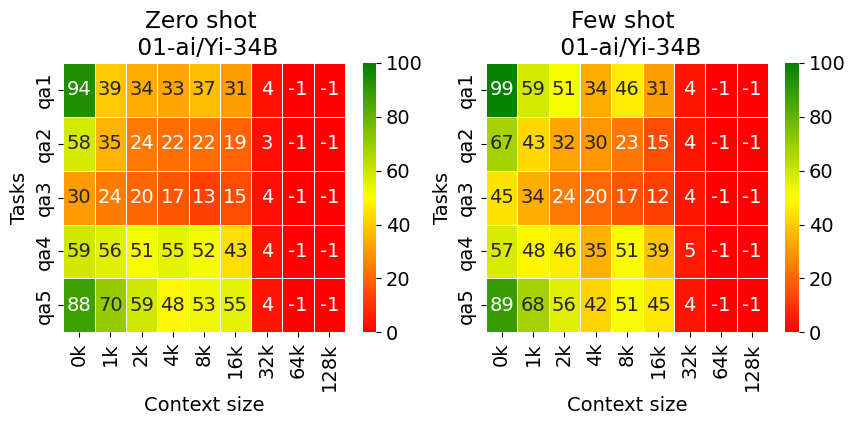

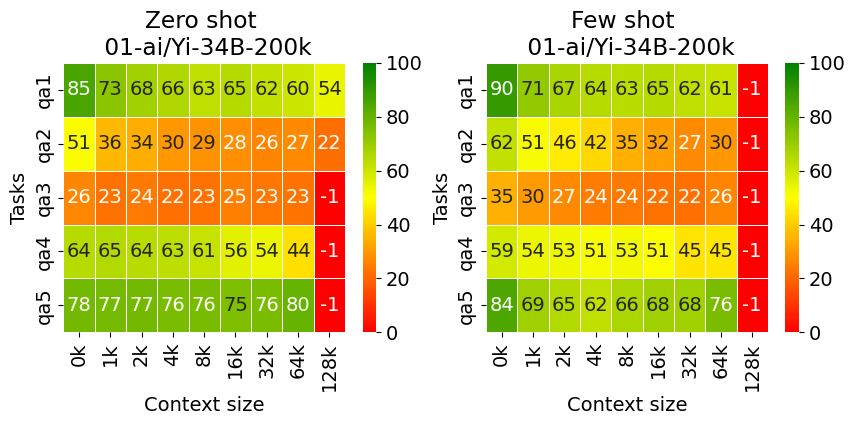

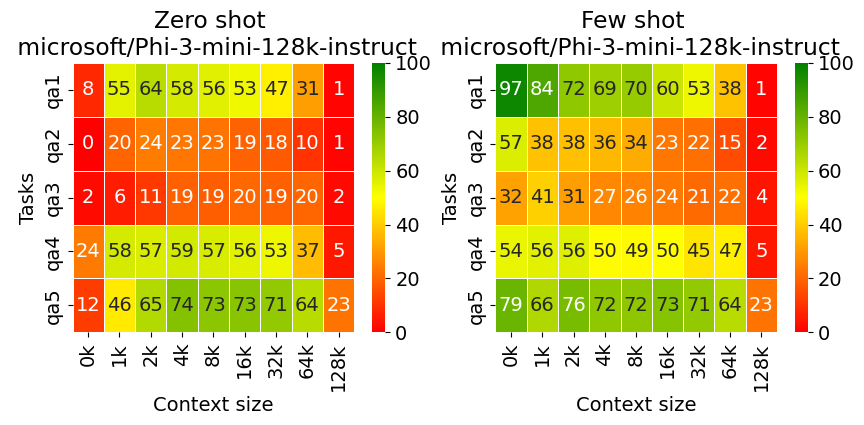

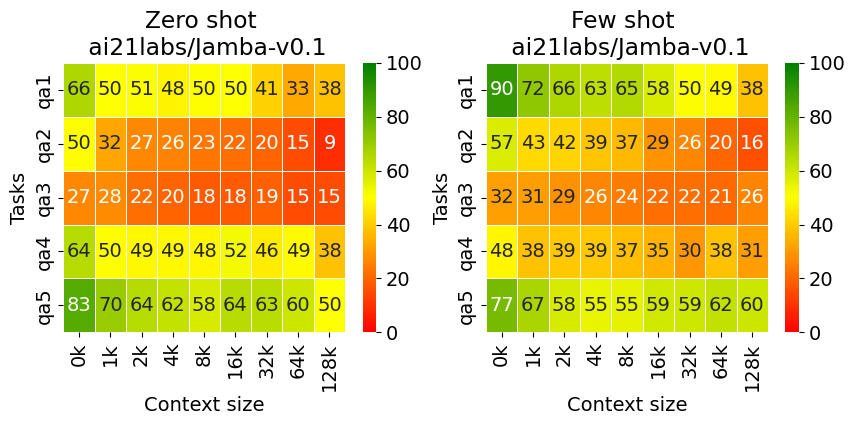

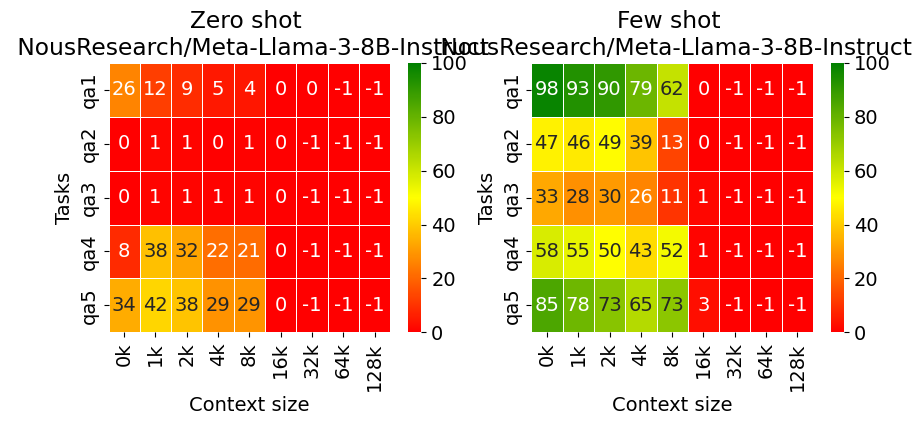

In [6]:
results = {}
for model_name in model_names:
    prompt_name = 'instruction_no_examples_no_post_prompt_no'
    accuracy = np.ones((len(tasks), len(lengths))) * -1
    try:
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
                if not os.path.isfile(fname):
                    # print(f'No such file: {fname}')
                    continue
                
                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'
        accuracy_fs = np.ones((len(tasks), len(lengths))) * -1
        for j, task in enumerate(tasks):
            for i, ctx_length in enumerate(lengths):
                fname = f'{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
                if not os.path.isfile(fname):
                    # print(f'No such file: {fname}')
                    continue
                
                df = pd.read_csv(fname)
                
                if df['output'].dtype != object:
                    df['output'] = df['output'].astype(str)
                df['output'] = df['output'].fillna('')


                df['correct'] = df.apply(lambda row: compare_answers(target=row['target'], output=row['output'], question=row['question'],
                                                                     task_labels=TASK_LABELS[task]), axis=1)
                score = df['correct'].sum()
                accuracy_fs[j, i] = 100 * score / len(df) if len(df) > 0 else 0

        results[model_name] = {'zero': accuracy, 'few': accuracy_fs}
        

        # Set large font sizes for better visibility in the PDF
        matplotlib.rc('font', size=14)

        # Create a colormap for the heatmap
        cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

        # Create the heatmap
        fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))  # Adjust the size as necessary
        
        sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[0])
        
        sns.heatmap(accuracy_fs, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
                    linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax[1])
        
        ax[0].set_title(f'Zero shot \n {model_name}')
        ax[1].set_title(f'Few shot \n {model_name}')
        ax[0].set_xlabel('Context size')
        ax[1].set_xlabel('Context size')
        ax[0].set_ylabel('Tasks')
        ax[1].set_ylabel('Tasks')

        # Save the figure to a PDF
        # plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
        plt.show()
    except KeyError as e:
        print(f"question not found in {model_name}")
        continue
        

### Visualize the results to copy-paste

In [7]:
results.keys()

dict_keys(['01-ai/Yi-34B', '01-ai/Yi-34B-200k', 'microsoft/Phi-3-mini-128k-instruct', 'ai21labs/Jamba-v0.1', 'NousResearch/Meta-Llama-3-8B-Instruct'])

In [8]:
mn = "01-ai/Yi-34B"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,99,59,51,34,46,31,4,-1,-1
qa2,67,43,32,30,23,15,4,-1,-1
qa3,45,34,24,20,17,12,4,-1,-1
qa4,59,56,51,55,52,43,4,-1,-1
qa5,88,70,59,48,53,55,4,-1,-1


In [9]:
mn = "01-ai/Yi-34B-200k"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)[best_tab.columns[:-1]]

,0k,1k,2k,4k,8k,16k,32k,64k,128k
qa1,85,73,68,66,63,65,62,60,54
qa2,62,51,46,42,35,32,27,30,-1
qa3,35,30,27,24,24,22,22,26,-1
qa4,64,65,64,63,61,56,54,44,-1
qa5,78,77,77,76,76,75,76,80,-1


In [10]:
mn = "microsoft/Phi-3-mini-128k-instruct"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

best_tab.round().astype(int)

,0k,1k,2k,4k,8k,16k,32k,64k,128k,avg
qa1,97,84,72,69,70,60,53,38,1,61
qa2,57,38,38,36,34,23,22,15,2,29
qa3,32,41,31,27,26,24,21,22,4,25
qa4,54,56,56,50,49,50,45,47,5,46
qa5,79,66,76,72,72,73,71,64,23,66


In [11]:
mn = "ai21labs/Jamba-v0.1"

tab = results[mn]['zero']
tab = pd.DataFrame(tab, index=tasks, columns=lengths[:tab.shape[1]])

tab_few = results[mn]['few']
tab_few = pd.DataFrame(tab_few, index=tasks, columns=lengths[:tab_few.shape[1]])

tab['avg'] = tab.mean(axis=1)
tab_few['avg'] = tab_few.mean(axis=1)

best_tab = tab_few.copy()
for i, row in tab.iterrows():
    if row.avg > best_tab.loc[i].avg:
        best_tab.loc[i] = row

In [12]:
best_tab.round().astype(int)

,0k,1k,2k,4k,8k,16k,32k,64k,128k,avg
qa1,90,72,66,63,65,58,50,49,38,61
qa2,57,43,42,39,37,29,26,20,16,34
qa3,32,31,29,26,24,22,22,21,26,26
qa4,64,50,49,49,48,52,46,49,38,49
qa5,83,70,64,62,58,64,63,60,50,64
